#### Connect to Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
cd '/content/drive/MyDrive/FYP/Project/Neural network'

/content/drive/MyDrive/FYP/Project/Neural network


### Dataset Loading

In [13]:
!pip install torchinfo

In [14]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

from torch import nn
import torch.optim as optim
from torchinfo import summary

In [15]:
df = pd.read_csv('data_preprocessed.csv')

In [16]:
# split train test set
from sklearn.model_selection import train_test_split

y = df[df.columns[-1]]
X = df.drop(df.columns[-1], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#### Dataloader

In [17]:
from torch.utils.data import DataLoader, Dataset

In [18]:
# Customize Dataset

class MyDataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    # Get data and label from your dataframe
    data = torch.tensor(self.data.iloc[idx].to_numpy(), requires_grad=True, dtype=torch.float32)# Replace with your feature columns
    label = torch.tensor(self.labels.iloc[idx], requires_grad=True, dtype=torch.float32)  # Replace with your label column

    return data, label

In [19]:
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)

In [20]:
# handpick batch_size
trainloader = DataLoader(trainset, 128, True)
testloader = DataLoader(testset, 128, True)

#### Helper function

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
def evaluate_acc(net, dataloader):
  net.eval()
  inputs, labels = next(iter(dataloader))

  inputs = inputs.to(device)
  labels = labels.to(device)

  with torch.no_grad():
    running_corrects = 0
    outputs = net(inputs)
    predicted = outputs.ravel() >= 0.5
    running_corrects += (labels == predicted).double().sum()

  acc = running_corrects/len(labels)

  labels = labels.reshape(-1, 1).float()
  with torch.no_grad():
    loss = F.binary_cross_entropy(outputs, labels)

  return acc.to('cpu'), loss.item()

In [23]:
# train function

def train(net, trainloader=trainloader, testloader=testloader, device=device, num_epochs=15, lr=0.1, momentum=0.9, verbose=False):
  loss_iterations = int(np.ceil(len(trainloader)/3))

  # transfer to model to GPU
  net = net.to(device)

  # optimizer
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

  # set to training mode
  # net.train()

  # variables
  best_loss = np.inf
  saturated_count = 0

  history = {'iter' : [], 'training_cost': [], 'testing_cost': [], 'acc_train' : [], 'acc_val' : [] }

  # train network
  for e in range(num_epochs):

    net.train()
    running_loss = 0
    running_count = 0

    epoch_loss = 0
    epoch_count = 0

    for i, (inputs, labels) in enumerate(trainloader):

      labels = labels.reshape(-1, 1).float()

      # clear gradient to zero
      optimizer.zero_grad()

      # transfer data to GPU
      inputs = inputs.to(device)
      labels = labels.to(device)

      # forward prop
      outs = net(inputs)

      # compute loss
      loss = F.binary_cross_entropy(outs, labels)

      # backprop
      loss.backward()

      # update params
      optimizer.step()

      # get the loss of training
      running_loss += loss.item()
      running_count += 1

      epoch_loss += loss.item()
      epoch_count += 1

      # display the averaged loss value
      if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:
        train_loss = running_loss / running_count
        running_loss = 0.
        running_count = 0.

        if verbose:
          print(f'[Epoch {e+1:2d} Iter {i+1:5d}/{len(trainloader)}]: train_loss = {train_loss:.4f}')

    train_acc, train_loss = evaluate_acc(net, trainloader)
    test_acc, test_loss = evaluate_acc(net, testloader)

    if verbose:
      print(f'Train acc: {train_acc:.4f}')
      print(f'Test acc: {test_acc:.4f}\n')

    # store cost

    history['training_cost'].append(epoch_loss/epoch_count)
    epoch_loss = 0
    epoch_count = 0

    history['testing_cost'].append(test_loss)

    # Compute the training and validation accuracy
    history['iter'].append(e)

    acc_train, _ = evaluate_acc(net, trainloader)
    history['acc_train'].append(acc_train)

    acc_val, _ = evaluate_acc(net, testloader)
    history['acc_val'].append(acc_val)

  return history


In [24]:
# evaluate function

def evaluate(net, dataloader, device=device):
  # set to eval mode
  net.eval()

  running_corrects = 0

  # repeat for all batch data in test set
  for inputs, targets in dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)

    # disable gradient computation
    with torch.no_grad():
      outputs = net(inputs)
      predicted = outputs.ravel() >= 0.5
      running_corrects += (targets == predicted).double().sum()

    acc = running_corrects/len(dataloader.dataset)
    acc = acc.to("cpu")

  return acc

#### Neural Network setup

In [25]:
class Net(nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        # layers here
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(in_features=51, out_features=layer_size[0]))

        for i in range(1, len(layer_size)):
          self.layers.append(nn.Linear(layer_size[i-1], layer_size[i]))

    def forward(self, x):

        # forward prop
        for layer in self.layers[:-1]:
          x = torch.relu(layer(x))

        x = torch.sigmoid(self.layers[-1](x))

        return x

In [ ]:
# Baseline model (handpick hyperparams)
net1 = Net((200, 300, 100, 70, 1))

In [ ]:
col_names = ["input_size", "output_size", "num_params", "mult_adds", "trainable"]
summary(net1, input_size=(32, 51), col_names=col_names)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Net                                      [32, 51]                  [32, 1]                   --                        --                        True
├─ModuleList: 1-1                        --                        --                        --                        --                        True
│    └─Linear: 2-1                       [32, 51]                  [32, 200]                 10,400                    332,800                   True
│    └─Linear: 2-2                       [32, 200]                 [32, 300]                 60,300                    1,929,600                 True
│    └─Linear: 2-3                       [32, 300]                 [32, 100]                 30,100                    963,200                   True
│    └─Linear: 2-4                       [32, 100]                 [32, 70]                  7,

In [ ]:
# handpick hyperparams (epochs, lr, default momentum = 0.9)
history = train(net1, trainloader, device, num_epochs=24, lr=0.005)

[Epoch  1 Iter    20/58]: train_loss = 0.6800
[Epoch  1 Iter    40/58]: train_loss = 0.6684
[Epoch  1 Iter    58/58]: train_loss = 0.6613
[Epoch  2 Iter    20/58]: train_loss = 0.6401
[Epoch  2 Iter    40/58]: train_loss = 0.6215
[Epoch  2 Iter    58/58]: train_loss = 0.5579
[Epoch  3 Iter    20/58]: train_loss = 0.4400
[Epoch  3 Iter    40/58]: train_loss = 0.3215
[Epoch  3 Iter    58/58]: train_loss = 0.3021
[Epoch  4 Iter    20/58]: train_loss = 0.2752
[Epoch  4 Iter    40/58]: train_loss = 0.2571
[Epoch  4 Iter    58/58]: train_loss = 0.3163
[Epoch  5 Iter    20/58]: train_loss = 0.2863
[Epoch  5 Iter    40/58]: train_loss = 0.2645
[Epoch  5 Iter    58/58]: train_loss = 0.2463
[Epoch  6 Iter    20/58]: train_loss = 0.2479
[Epoch  6 Iter    40/58]: train_loss = 0.2399
[Epoch  6 Iter    58/58]: train_loss = 0.2433
[Epoch  7 Iter    20/58]: train_loss = 0.2399
[Epoch  7 Iter    40/58]: train_loss = 0.2475
[Epoch  7 Iter    58/58]: train_loss = 0.2287
[Epoch  8 Iter    20/58]: train_lo

In [ ]:
evaluate(net1, testloader, device)

acc = 0.8588


#### Plot function

In [26]:
def plot_history_cost(history):
    plt.plot(history['iter'], history['training_cost'], label='train_cost', color='red')
    plt.plot(history['iter'], history['testing_cost'], label='test_cost', color='blue')
    plt.ylabel('Cost', fontsize=13)
    plt.xlabel('Epochs', fontsize=13)
    plt.title('Cost vs Epochs', fontsize=18)
    plt.legend()
    plt.show()

In [27]:
def plot_history_acc(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history['iter'], history['acc_train'], color='red', label='acc_train')
    plt.plot(history['iter'], history['acc_val'], color='blue', label='acc_val')
    plt.ylabel('Accuracy', fontsize=13)
    plt.xlabel('Epochs', fontsize=13)
    plt.title('Training vs Validation Accuracy', fontsize=18)
    plt.legend()
    plt.show()

#### Implement Bayesian Optimization

In [ ]:
!pip install optuna
!pip install optuna-dashboard

In [ ]:
import optuna
from optuna import samplers, pruners
import optuna_dashboard
import time
import joblib

import threading
from google.colab import output
from optuna_dashboard import run_server

In [ ]:
# Hyperparams to tune
'''
1. num_layer = 5 (fixed)
2. number of neuron of each layer
3. learning rate
4. momentum
5. number of epoch
6. Batch size
'''

def objective(trial):
  # suggest hyperparam values
  lr = trial.suggest_float("lr", 1e-4, 1e-1)
  num_neuron = [trial.suggest_int("num_layer_1", 10, 200),
                trial.suggest_int("num_layer_2", 10, 200),
                trial.suggest_int("num_layer_3", 10, 200),
                trial.suggest_int("num_layer_4", 10, 200),
                trial.suggest_int("num_layer_5", 10, 200),
                1]

  momentum = trial.suggest_float("momentum",  0.5, 1.0)
  num_of_epoch = trial.suggest_int("num_of_epoch", 8, 64)

  batch_size = trial.suggest_int("batch_size", 4, 128)
  
  # training & evaluate
  trainloader = DataLoader(trainset, batch_size, True)
  testloader = DataLoader(testset, batch_size, True)

  net = Net(num_neuron)
  _ = train(net, trainloader, device, num_epochs=num_of_epoch, lr=lr, momentum=momentum)
  acc = evaluate(net, testloader, device)

  return acc

In [ ]:
# Create Optuna study
storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(direction="maximize", storage=storage, sampler=samplers.GPSampler(), pruner=pruners.MedianPruner(n_min_trials=15), study_name="Bayesian Optimization") # using Gaussian Process-based Sampler to perform Bayesian Optimization

<ipython-input-22-171180a85cb4>:3: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(direction="maximize", storage=storage, sampler=samplers.GPSampler(), pruner=pruners.MedianPruner(n_min_trials=15), study_name="Bayesian Optimization") # using Gaussian Process-based Sampler to perform Bayesian Optimization
[I 2024-04-09 10:46:35,156] A new study created in memory with name: Bayesian Optimization


In [ ]:
# calculate the time require for Bayesian Optimization search
start_time = time.time()
study.optimize(objective, n_trials=150)  # Adjust number of trials as needed
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Optimization Time: {elapsed_time:.2f} seconds")

# Access best trial results
best_trial = study.best_trial
best_params = best_trial.params

[I 2024-04-09 10:48:31,019] Trial 0 finished with value: 0.9107142857142857 and parameters: {'lr': 0.012345433065489818, 'num_layer_1': 85, 'num_layer_2': 31, 'num_layer_3': 70, 'num_layer_4': 180, 'num_layer_5': 117, 'momentum': 0.8712447925673371, 'num_of_epoch': 52, 'batch_size': 44}. Best is trial 0 with value: 0.9107142857142857.
[I 2024-04-09 10:50:00,584] Trial 1 finished with value: 0.808982683982684 and parameters: {'lr': 0.09130235698160151, 'num_layer_1': 184, 'num_layer_2': 74, 'num_layer_3': 23, 'num_layer_4': 131, 'num_layer_5': 152, 'momentum': 0.6755825863868192, 'num_of_epoch': 46, 'batch_size': 101}. Best is trial 0 with value: 0.9107142857142857.
[I 2024-04-09 10:50:31,740] Trial 2 finished with value: 0.5946969696969697 and parameters: {'lr': 0.08666716185390629, 'num_layer_1': 182, 'num_layer_2': 145, 'num_layer_3': 141, 'num_layer_4': 49, 'num_layer_5': 41, 'momentum': 0.9687645391654904, 'num_of_epoch': 13, 'batch_size': 45}. Best is trial 0 with value: 0.9107142

Optimization Time: 21205.45 seconds


In [ ]:
# Optimization Time: 21205.45 seconds

In [ ]:
print(best_params)

{'lr': 0.012345433065489818, 'num_layer_1': 85, 'num_layer_2': 31, 'num_layer_3': 70, 'num_layer_4': 180, 'num_layer_5': 117, 'momentum': 0.8712447925673371, 'num_of_epoch': 52, 'batch_size': 44}


In [ ]:
lr = best_params['lr']
momentum = best_params['momentum']
num_of_epoch = best_params['num_of_epoch']


print('lr: ', lr)
for i in range(1, 6):
  print(f'num_layer_{i}: {best_params["num_layer_"+ str(i)]}')
print('momentum: ', momentum)
print('num_of_epoch: ', num_of_epoch)
print(f'batch_size: {best_params["batch_size"]}')

lr:  0.012345433065489818
num_layer_1: 85
num_layer_2: 31
num_layer_3: 70
num_layer_4: 180
num_layer_5: 117
momentum:  0.8712447925673371
num_of_epoch:  52
batch_size: 44


In [ ]:
# store the storage and study for further analysis on the optimization process

joblib.dump(study, 'bayesopt_study.pkl')
joblib.dump(storage, "bayesopt_storage.pkl")

# to load in future
# loaded_study = joblib.load('my_study.pkl')

['bayesopt_storage.pkl']

### Result Analysis

In [28]:
!pip install scikit_plot

In [29]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix, plot_precision_recall

In [30]:
def prediction(dataloader, net):
  all_pred = []
  all_true = []
  all_proba = []

  for data, label in dataloader:
    net.eval()
    net = net.to('cpu')

    with torch.no_grad():
      y_proba = net(data)
      y_pred = y_proba.ravel() >= 0.5
      y_true = label.detach()

    all_pred.extend(y_pred)
    all_true.extend(y_true)
    all_proba.extend(y_proba)

    all_proba = [torch.tensor(tensor.item()) for tensor in all_proba]

  return all_pred, all_true, all_proba

In [31]:
def eval_performance(net, y_pred, y_true, y_proba, plot=False):

  # confusion matrix
  if plot:
    plot_confusion_matrix(y_true, y_pred)

    # y_probas == (prob for class 0, prob for class 1)
    # y_proba == prob for class 1
    # hence, the arrange of y_probas == (1-y_proba, y_proba)
    y_probas = [[y, x] for x, y in zip(np.array(y_proba), 1-np.array(y_proba))]

    plot_roc(torch.tensor(y_true), torch.tensor(y_probas))

    plot_precision_recall(y_true, y_probas)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')

    plt.show()

  acc = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc_score = roc_auc_score(y_true, y_proba)


  print(f"recall score: {recall:.4f}")
  print(f"Precision score: {precision:.4f}")
  print(f"F1 score: {f1:.4f}")
  print(f"ROC_AUC score: {roc_score:.4f}")
  print(f"Accuracy Score: {acc:.4f}\n")

  return acc, recall, precision, f1, roc_score

#### Train with best hyperparameter found

In [32]:
# Best Hyperparams
'''
lr:  0.012345433065489818
num_layer_1: 85
num_layer_2: 31
num_layer_3: 70
num_layer_4: 180
num_layer_5: 117
momentum:  0.8712447925673371
num_of_epoch:  52
batch_size: 44
'''

net1 = Net([85, 31, 70, 180, 117, 1])

trainloader = DataLoader(trainset, 44, shuffle=True)
testloader = DataLoader(testset, 44, shuffle=True)

history = train(net1, num_epochs=52, lr=0.012345433065489818, momentum=0.8712447925673371, verbose=True)

[Epoch  1 Iter    20/58]: train_loss = 0.6867
[Epoch  1 Iter    40/58]: train_loss = 0.6706
[Epoch  1 Iter    58/58]: train_loss = 0.6778
Train acc: 0.6094
Test acc: 0.5625

[Epoch  2 Iter    20/58]: train_loss = 0.6696
[Epoch  2 Iter    40/58]: train_loss = 0.6621
[Epoch  2 Iter    58/58]: train_loss = 0.6600
Train acc: 0.6484
Test acc: 0.5938

[Epoch  3 Iter    20/58]: train_loss = 0.6336
[Epoch  3 Iter    40/58]: train_loss = 0.5407
[Epoch  3 Iter    58/58]: train_loss = 0.4313
Train acc: 0.8672
Test acc: 0.7969

[Epoch  4 Iter    20/58]: train_loss = 0.3471
[Epoch  4 Iter    40/58]: train_loss = 0.6193
[Epoch  4 Iter    58/58]: train_loss = 0.3838
Train acc: 0.9219
Test acc: 0.8672

[Epoch  5 Iter    20/58]: train_loss = 0.3137
[Epoch  5 Iter    40/58]: train_loss = 0.2726
[Epoch  5 Iter    58/58]: train_loss = 0.2798
Train acc: 0.8438
Test acc: 0.8047

[Epoch  6 Iter    20/58]: train_loss = 0.3141
[Epoch  6 Iter    40/58]: train_loss = 0.2756
[Epoch  6 Iter    58/58]: train_loss =

In [33]:
all_pred, all_true, all_proba = prediction(trainloader, net1)

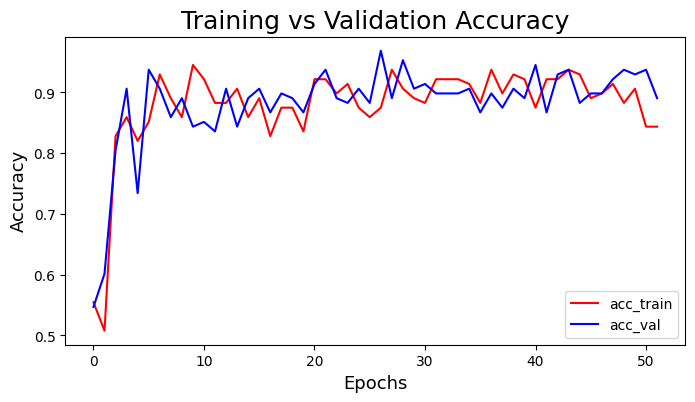

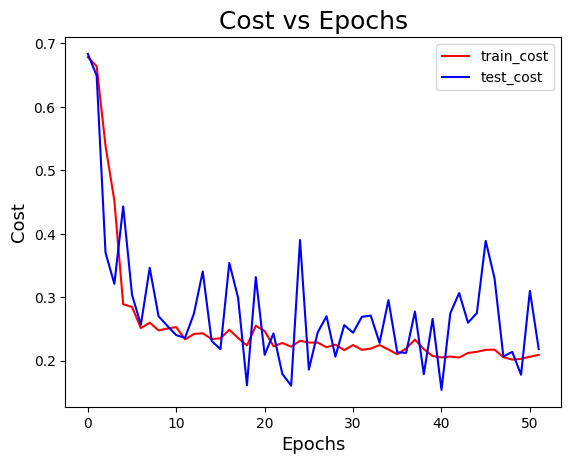

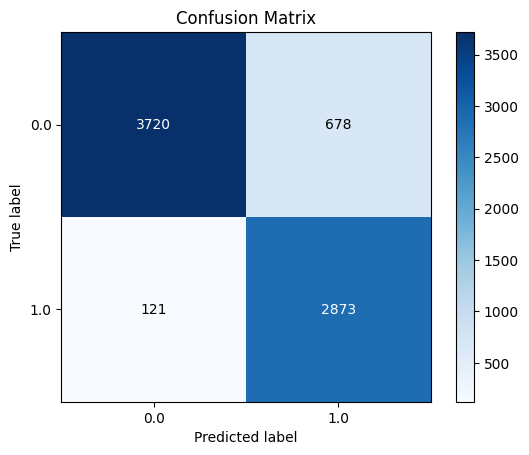

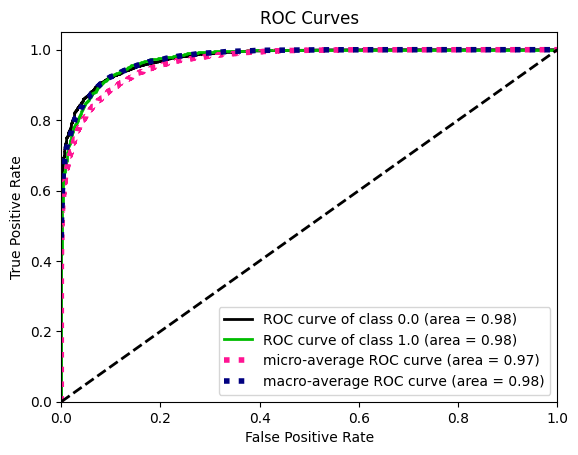

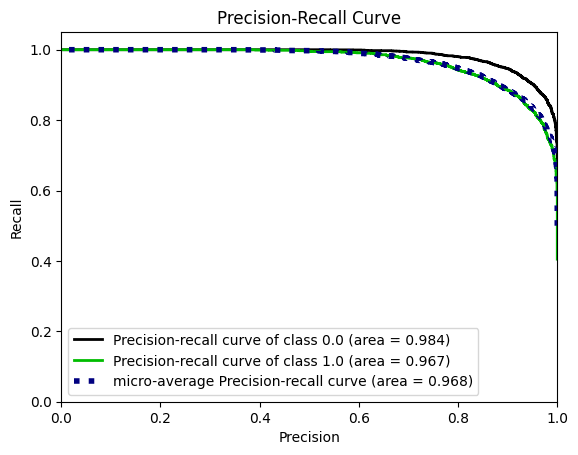

recall score: 0.9596
Precision score: 0.8091
F1 score: 0.8779
ROC_AUC score: 0.9759
Accuracy Score: 0.8919



In [34]:
plot_history_acc(history)
plot_history_cost(history)
_ = eval_performance(net1, all_pred, all_true, all_proba, True)

#### Cross Validation

In [35]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

all_acc = []
all_recall = []
all_precision = []
all_f1 = []
all_roc_score = []

all_train_acc = []
all_train_recall = []
all_train_precision = []
all_train_f1 = []
all_train_roc_score = []

# Iterate through each fold in KFold
for train_index, val_index in kfold.split(X_train):
  # initialize the network for each fold
  net = Net([85, 31, 70, 180, 117, 1])

  # Split data based on the current fold indices
  X_train_val, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train_val, y_val = y.iloc[train_index], y.iloc[val_index]

  train_val_set = MyDataset(X_train_val, y_train_val)
  val_set = MyDataset(X_val, y_val)

  train_val_loader = DataLoader(train_val_set, batch_size=44, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=44, shuffle=True)

  # Train your machine learning model here using X_train and y_train
  net.train()
  history = train(net, train_val_loader, val_loader, device, 52, 0.012345433065489818, momentum=0.8712447925673371)

  # Evaluate the model's performance on the training set (X_train_val, y_train_val)
  print("****************\n"+
        "Train performance:"+
        "\n****************")
  all_pred, all_true, all_proba = prediction(train_val_loader, net)
  train_acc, train_recall, train_precision, train_f1, train_roc_score = eval_performance(net, all_pred, all_true, all_proba)

  all_train_acc.append(train_acc)
  all_train_recall.append(train_recall)
  all_train_precision.append(train_precision)
  all_train_f1.append(train_f1)
  all_train_roc_score.append(train_roc_score)

  # and validation set (X_val, y_val)
  print("**********************\n"+
        "Validation performance:"+
        "\n**********************")
  all_pred, all_true, all_proba = prediction(val_loader, net)
  acc, recall, precision, f1, roc_score = eval_performance(net, all_pred, all_true, all_proba)

  all_acc.append(acc)
  all_recall.append(recall)
  all_precision.append(precision)
  all_f1.append(f1)
  all_roc_score.append(roc_score)

****************
Train performance:
****************
recall score: 0.8936
Precision score: 0.9047
F1 score: 0.8991
ROC_AUC score: 0.9796
Accuracy Score: 0.9200

**********************
Validation performance:
**********************
recall score: 0.8368
Precision score: 0.8732
F1 score: 0.8546
ROC_AUC score: 0.9629
Accuracy Score: 0.8891

****************
Train performance:
****************
recall score: 0.9460
Precision score: 0.8506
F1 score: 0.8958
ROC_AUC score: 0.9789
Accuracy Score: 0.9124

**********************
Validation performance:
**********************
recall score: 0.9244
Precision score: 0.7982
F1 score: 0.8567
ROC_AUC score: 0.9639
Accuracy Score: 0.8783

****************
Train performance:
****************
recall score: 0.8777
Precision score: 0.9240
F1 score: 0.9003
ROC_AUC score: 0.9810
Accuracy Score: 0.9226

**********************
Validation performance:
**********************
recall score: 0.8483
Precision score: 0.9011
F1 score: 0.8739
ROC_AUC score: 0.9685
Accurac

In [36]:
# get the average of each metric for training and validation
print(f"\nAvg training accuracy: \t\t{sum(all_train_acc)/len(all_train_acc):.4f}")
print(f"Avg training recall: \t\t{sum(all_train_recall)/len(all_train_recall):.4f}")
print(f"Avg training precision: \t{sum(all_train_precision)/len(all_train_precision):.4f}")
print(f"Avg training f1: \t\t{sum(all_train_f1)/len(all_train_f1):.4f}")
print(f"Avg training ROC score: \t{sum(all_train_roc_score)/len(all_train_roc_score):.4f}")

print(f"\nAvg validation accuracy: \t{sum(all_acc)/len(all_acc):.4f}")
print(f"Avg validation recall: \t\t{sum(all_recall)/len(all_recall):.4f}")
print(f"Avg validation precision: \t{sum(all_precision)/len(all_precision):.4f}")
print(f"Avg validation f1: \t\t{sum(all_f1)/len(all_f1):.4f}")
print(f"Avg validation ROC score: \t{sum(all_roc_score)/len(all_roc_score):.4f}")


Avg training accuracy: 		0.9140
Avg training recall: 		0.8896
Avg training precision: 	0.8973
Avg training f1: 		0.8909
Avg training ROC score: 	0.9789

Avg validation accuracy: 	0.8891
Avg validation recall: 		0.8560
Avg validation precision: 	0.8684
Avg validation f1: 		0.8592
Avg validation ROC score: 	0.9655


#### Test Set inference

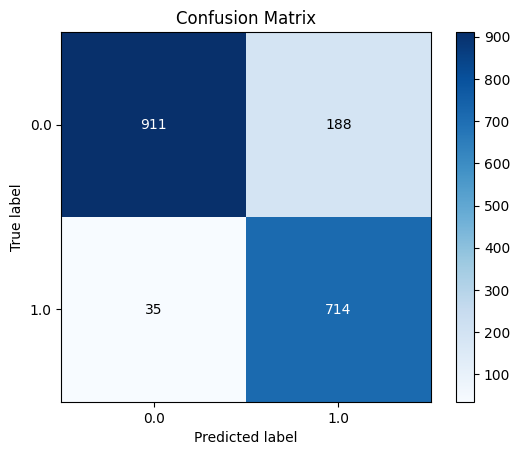

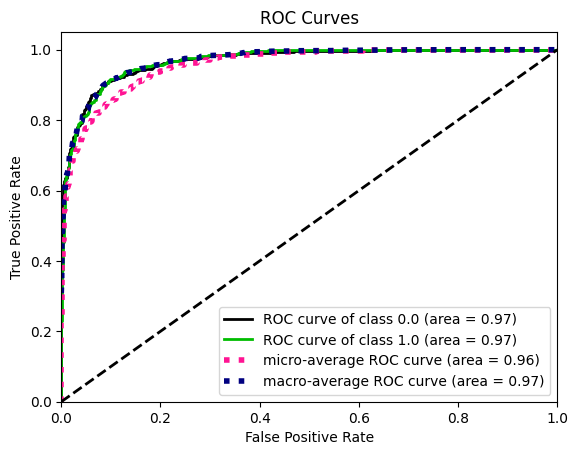

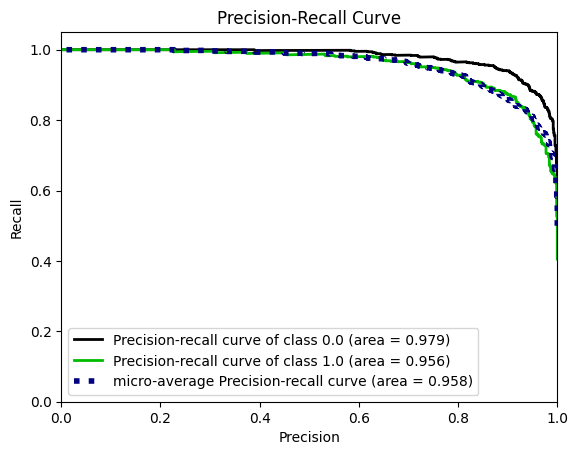

recall score: 0.9533
Precision score: 0.7916
F1 score: 0.8649
ROC_AUC score: 0.9684
Accuracy Score: 0.8793



In [37]:
all_pred, all_true, all_proba = prediction(testloader, net1)
acc, recall, precision, f1, roc_score = eval_performance(net1, all_pred, all_true, all_proba, True)

#### Comparison between Train, Cross Val, Test performance

In [38]:
# Train set performance
'''
recall score: 0.9596
Precision score: 0.8091
F1 score: 0.8779
ROC_AUC score: 0.9759
Accuracy Score: 0.8919
'''

# Test set performance
'''
recall score: 0.9533
Precision score: 0.7916
F1 score: 0.8649
ROC_AUC score: 0.9684
Accuracy Score: 0.8793
'''

# Cross Val performance
'''
Avg training accuracy: 		0.9140
Avg training recall: 		0.8896
Avg training precision: 	0.8973
Avg training f1: 		0.8909
Avg training ROC score: 	0.9789

Avg validation accuracy: 	0.8891
Avg validation recall: 		0.8560
Avg validation precision: 	0.8684
Avg validation f1: 		0.8592
Avg validation ROC score: 	0.9655
'''

# Conclusion: training performance are slightly better than validation / testing, suspect model to have slightly overfitting issue

# Comparison: Recall are slightly higher than randopt model, similar overall performance for both model

'\nAvg training accuracy: \t\t0.9104\nAvg training recall: \t\t  0.9067\nAvg training precision: \t0.8787\nAvg training f1: \t\t      0.8896\nAvg training ROC score: \t0.9794\n\nAvg validation accuracy: \t  0.8889\nAvg validation recall: \t\t  0.8817\nAvg validation precision: \t0.8511\nAvg validation f1: \t\t      0.8633\nAvg validation ROC score: \t0.9667\n'

In [39]:
# Store the weight & bias of network trained
torch.save(net1, "bayes.pt")

#### Test model with sample input

In [40]:
net1.eval()
x_eval, y_eval = next(iter(testloader))
correct = 0
yhat = net1(x_eval)

ypred = yhat.ravel() >= 0.5

correct = (y_eval == ypred).double().sum()
acc = correct / len(y_eval)
print(acc)

tensor(0.9545, dtype=torch.float64)


In [41]:
a = np.random.randint(0, X_test.shape[0])

X_test_np = X_test.iloc[a].to_numpy()
y_test_np = y_test.iloc[a]

input = torch.tensor(X_test_np, dtype=torch.float32)
output = torch.tensor(y_test_np, dtype=torch.float32)

y_score = net1(input)
y_pred = y_score.ravel() >= 0.5
print(f'output: {output}, y_pred: {y_pred}, y_score: {y_score}')

# if prediction == "0", then winner == "ct"
if y_pred:
  winner = "T"
else:
  winner = "CT"

print(f"The winner is {winner}")

output: 1.0, y_pred: tensor([True]), y_score: tensor([0.9419], grad_fn=<SigmoidBackward0>)
The winner is T
